In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import PowerTransformer

import statsmodels.api as sm
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.feature_selection import SelectKBest

from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error,make_scorer,r2_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

In [2]:
import random
np.random.seed(42)
random.seed(42)

In [3]:
df_diamonds = pd.read_csv("diamonds.csv")

In [4]:
df_diamond = df_diamonds.drop(columns = "Unnamed: 0")

In [5]:
train_set, test_set = train_test_split(df_diamond, test_size = 0.2)

In [6]:
train_features = train_set.drop(columns = "price")
train_labels = pd.DataFrame(train_set["price"])

test_features = test_set.drop(columns = "price")
test_labels = pd.DataFrame(test_set["price"])


In [7]:
#Pipeline only cat
num_attributes = ["carat","depth","table","x","y","z"]
cat_cut_level = [['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']] 
cat_color_level = [['J', 'I', 'H', 'G', 'F', 'E', 'D']]
cat_clarity_level = [['I1', 'SI2', 'SI1', 'VS2','VS1', 'VVS2','VVS1', 'IF']]
cat_attributes= ["cut","color","clarity"]

full_pipeline_cat = ColumnTransformer(
    transformers = [
    ("cat_cut",     OrdinalEncoder(categories=cat_cut_level),["cut"]),
    ("cat_color",   OrdinalEncoder(categories=cat_color_level),["color"]),
    ("cat_clarity", OrdinalEncoder(categories=cat_clarity_level),["clarity"])
    ],
    remainder = "passthrough"
)
    
train_features_cat = full_pipeline_cat.fit_transform(train_features)
test_features_cat = full_pipeline_cat.transform(test_features)

if(full_pipeline_cat.sparse_output_):
    train_features_cat = train_features_cat.toarray()
    test_features_cat = test_features_cat.toarray()
    
#Make them dataframe
df_train_features_cat = pd.DataFrame(train_features_cat, columns =  cat_attributes + num_attributes )
df_test_features_cat = pd.DataFrame(test_features_cat, columns = cat_attributes + num_attributes )

In [8]:
#Pipeline with standardscaler
num_attributes = ["carat","depth","table","x","y","z"]
all_atributes =  cat_attributes + num_attributes

num_pipeline_scaler = Pipeline([
    ('std_scaler',StandardScaler()),
])


full_pipeline_scaler = ColumnTransformer(
    transformers = [
    ("num", num_pipeline_scaler, all_atributes),
    ],
    remainder = "passthrough"
)
    

train_features_ss = full_pipeline_scaler.fit_transform(df_train_features_cat)
test_features_ss = full_pipeline_scaler.transform(df_test_features_cat)

if(full_pipeline_scaler.sparse_output_):
    train_features_ss = train_features_ss.toarray()
    test_features_ss = test_features_ss.toarray()
    
#Make them dataframe
df_train_features_ss = pd.DataFrame(train_features_ss, columns = all_atributes)
df_test_features_ss  = pd.DataFrame(test_features_ss, columns = all_atributes)

In [9]:
label_process_ss = StandardScaler()
train_labels_ss = label_process_ss.fit_transform(train_labels)
test_labels_ss = label_process_ss.transform(test_labels)
   
#Make them dataframe
df_train_labels_ss = pd.DataFrame(train_labels_ss, columns = ["price"])
df_test_labels_ss  = pd.DataFrame(test_labels_ss, columns = ["price"])

In [10]:
#3.3.1 
#Write the objective function

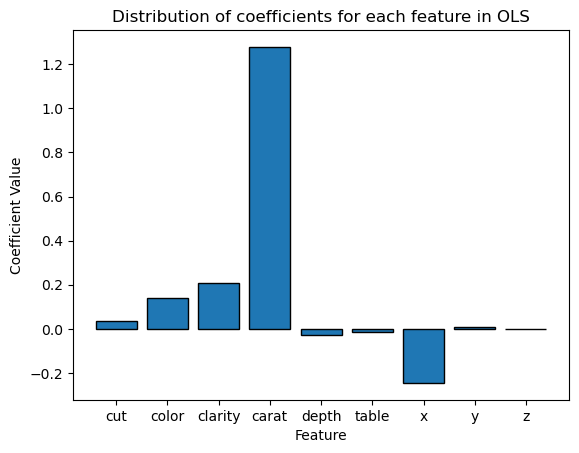

In [11]:
#Q4.1
lr_fit = LinearRegression().fit(df_train_features_ss,df_train_labels_ss)
OLS_coef = lr_fit.coef_.reshape(-1,)

plt.bar(np.arange(1,10),OLS_coef,edgecolor = "Black")
plt.xticks(np.arange(1,10), df_train_features_ss.columns)
plt.ylabel("Coefficient Value")
plt.xlabel("Feature")
plt.title("Distribution of coefficients for each feature in OLS")
plt.show()

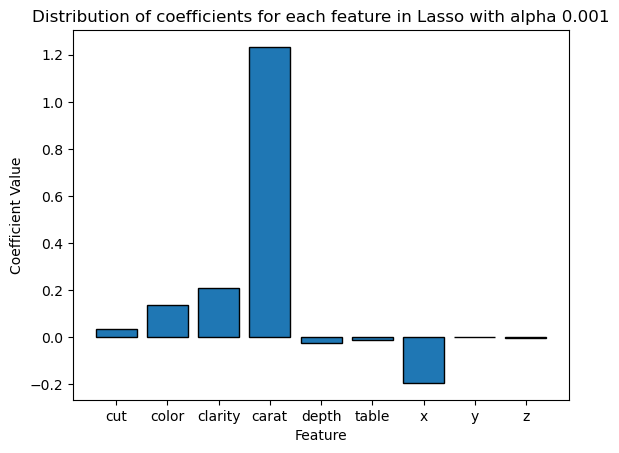

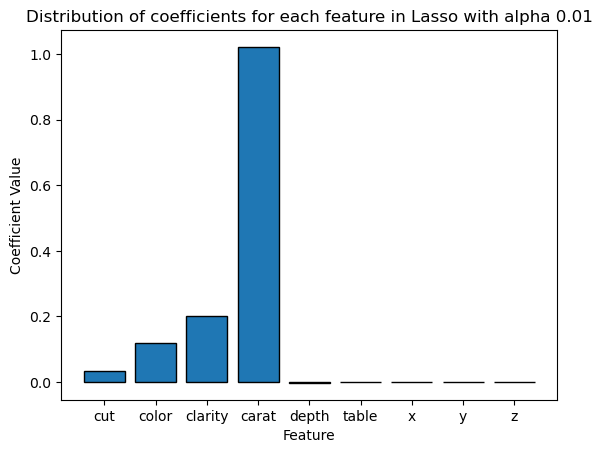

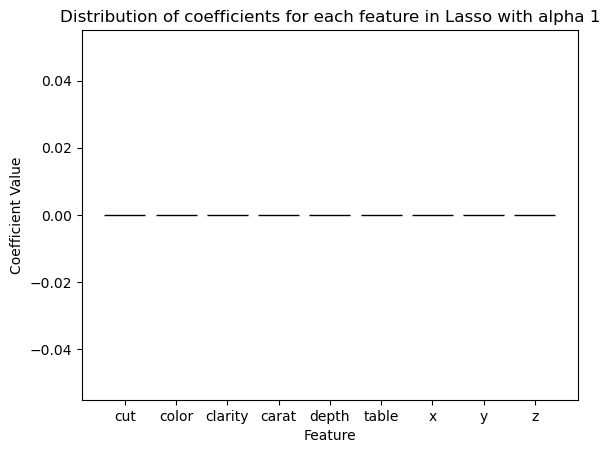

In [12]:
lasso_list = [1e-3,1e-2,1]
for alpha in lasso_list: 
    lr_fit = Lasso(alpha = alpha).fit(df_train_features_ss,df_train_labels_ss)
    Lasso_coef = lr_fit.coef_.reshape(-1,)

    plt.bar(np.arange(1,10),Lasso_coef,edgecolor = "Black")
    plt.xticks(np.arange(1,10), df_train_features_ss.columns)
    plt.ylabel("Coefficient Value")
    plt.xlabel("Feature")
    plt.title("Distribution of coefficients for each feature in Lasso with alpha " + str(alpha))
    plt.show()

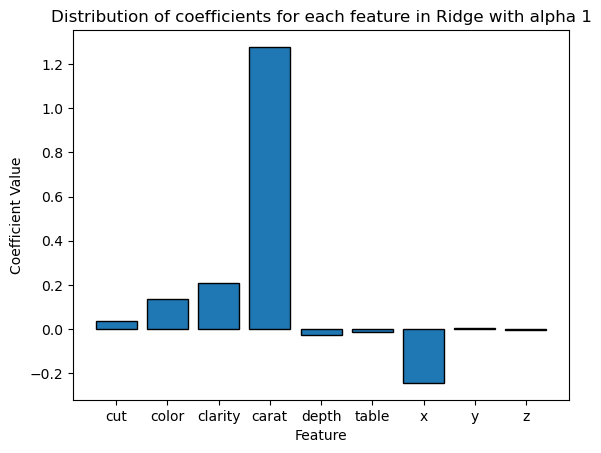

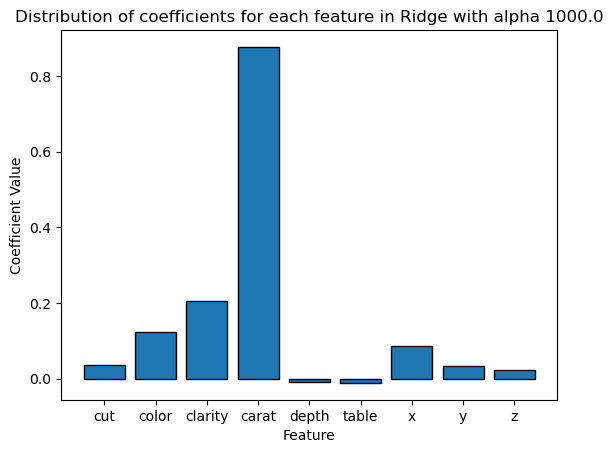

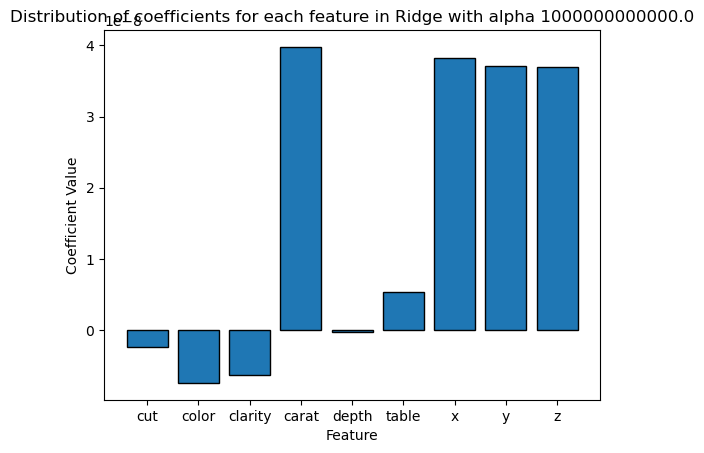

In [13]:
ridge_list = [1,1e3,1e12]
for alpha in ridge_list: 
    lr_fit = Ridge(alpha = alpha).fit(df_train_features_ss,df_train_labels_ss)
    Ridge_coef = lr_fit.coef_.reshape(-1,)

    plt.bar(np.arange(1,10),Ridge_coef,edgecolor = "Black")
    plt.xticks(np.arange(1,10), df_train_features_ss.columns)
    plt.ylabel("Coefficient Value")
    plt.xlabel("Feature")
    plt.title("Distribution of coefficients for each feature in Ridge with alpha " + str(alpha))
    plt.show()

In [14]:
#Question 4.2
default_pipeline = Pipeline([
    ('model',LinearRegression())
    ])

params = [
     {
          "model":[LinearRegression()]
     },
     {
          "model":[Ridge()],
          "model__alpha":[1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,1e1,1e2,1e3,1e4,1e5,1e6]
     },
     {
          "model":[Lasso()],
          "model__alpha":[1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,1e1,1e2,1e3,1e4,1e5,1e6]
     }
]

In [15]:
#KFold(n_splits=5, shuffle=False, random_state=42)
g_s = GridSearchCV(default_pipeline, params,cv=KFold(n_splits=10,shuffle = True, random_state = 42),n_jobs=-1, scoring=('neg_root_mean_squared_error'),verbose=10,
                    return_train_score=False)
g_s.fit(df_train_features_ss,df_train_labels_ss)

Fitting 10 folds for each of 27 candidates, totalling 270 fits


GridSearchCV(cv=KFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('model', LinearRegression())]),
             n_jobs=-1,
             param_grid=[{'model': [LinearRegression()]},
                         {'model': [Ridge()],
                          'model__alpha': [1e-06, 1e-05, 0.0001, 0.001, 0.01,
                                           0.1, 1, 10.0, 100.0, 1000.0, 10000.0,
                                           100000.0, 1000000.0]},
                         {'model': [Lasso(alpha=0.0001)],
                          'model__alpha': [1e-06, 1e-05, 0.0001, 0.001, 0.01,
                                           0.1, 1, 10.0, 100.0, 1000.0, 10000.0,
                                           100000.0, 1000000.0]}],
             scoring='neg_root_mean_squared_error', verbose=10)

In [16]:
df_g_s = pd.DataFrame(g_s.cv_results_)
sorted_g_s = df_g_s.sort_values(by='rank_test_score', ascending=True)

In [17]:
sorted_g_s[:20]

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model,param_model__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,split8_test_score,split9_test_score,mean_test_score,std_test_score,rank_test_score
16,0.276833,0.071768,0.004317,0.000988,Lasso(alpha=0.0001),0.0001,"{'model': Lasso(alpha=0.0001), 'model__alpha':...",-0.294095,-0.299184,-0.303991,-0.287050,-0.306681,-0.340744,-0.304928,-0.296650,-0.305528,-0.306986,-0.304584,0.013523,1
8,0.013189,0.001923,0.002312,0.000475,Ridge(),10.0,"{'model': Ridge(), 'model__alpha': 10.0}",-0.294068,-0.299233,-0.304006,-0.287188,-0.306714,-0.340526,-0.304965,-0.296708,-0.305987,-0.306901,-0.304630,0.013446,2
15,0.309638,0.121409,0.004663,0.001223,Lasso(alpha=0.0001),0.00001,"{'model': Lasso(alpha=0.0001), 'model__alpha':...",-0.294150,-0.299119,-0.303958,-0.286984,-0.306647,-0.340909,-0.304887,-0.296566,-0.306116,-0.307053,-0.304639,0.013585,3
7,0.017548,0.001915,0.002863,0.000571,Ridge(),1,"{'model': Ridge(), 'model__alpha': 1}",-0.294147,-0.299124,-0.303959,-0.286998,-0.306650,-0.340886,-0.304891,-0.296571,-0.306168,-0.307044,-0.304644,0.013577,4
14,0.335553,0.127734,0.004277,0.001062,Lasso(alpha=0.0001),0.000001,"{'model': Lasso(alpha=0.0001), 'model__alpha':...",-0.294156,-0.299113,-0.303955,-0.286978,-0.306644,-0.340925,-0.304883,-0.296557,-0.306184,-0.307060,-0.304645,0.013591,5
6,0.019470,0.001003,0.003626,0.000434,Ridge(),0.1,"{'model': Ridge(), 'model__alpha': 0.1}",-0.294155,-0.299113,-0.303955,-0.286979,-0.306644,-0.340923,-0.304884,-0.296558,-0.306189,-0.307059,-0.304646,0.013590,6
5,0.017640,0.001070,0.003762,0.000642,Ridge(),0.01,"{'model': Ridge(), 'model__alpha': 0.01}",-0.294156,-0.299112,-0.303954,-0.286977,-0.306644,-0.340927,-0.304883,-0.296557,-0.306192,-0.307061,-0.304646,0.013592,7
4,0.017201,0.001417,0.003254,0.000406,Ridge(),0.001,"{'model': Ridge(), 'model__alpha': 0.001}",-0.294156,-0.299112,-0.303954,-0.286977,-0.306644,-0.340927,-0.304883,-0.296556,-0.306192,-0.307061,-0.304646,0.013592,8
3,0.016220,0.000919,0.003829,0.001104,Ridge(),0.0001,"{'model': Ridge(), 'model__alpha': 0.0001}",-0.294156,-0.299112,-0.303954,-0.286977,-0.306644,-0.340927,-0.304883,-0.296556,-0.306192,-0.307061,-0.304646,0.013592,9
2,0.015126,0.001270,0.003003,0.000589,Ridge(),0.00001,"{'model': Ridge(), 'model__alpha': 1e-05}",-0.294156,-0.299112,-0.303954,-0.286977,-0.306644,-0.340927,-0.304883,-0.296556,-0.306192,-0.307061,-0.304646,0.013592,10


In [18]:
"""
#16 Lasso, #8 Ridge, #0 OLS
best_lasso_result = df_g_s.iloc[16]
best_ridge_result = df_g_s.iloc[8]
OLS_result = df_g_s.iloc[0]

print("Best Model: ", g_s.best_estimator_)
print("Best Lasso alpha: ", best_lasso_result["param_model__alpha"])
print("Best R2(LASSO): ",best_lasso_result["mean_test_score"])
print("\n")
print("Best Ridge alpha: ", best_ridge_result["param_model__alpha"])
print("Best R2(RIDGE): ",best_ridge_result["mean_test_score"])
print("\n")
print("OLS Score: ",OLS_result["mean_test_score"])
"""

#16 Lasso, #8 Ridge, #0 OLS
best_lasso_result = df_g_s.iloc[16]
best_ridge_result = df_g_s.iloc[8]
OLS_result = df_g_s.iloc[0]

print("Best Model: ", g_s.best_estimator_)
print("Best Lasso alpha: ", best_lasso_result["param_model__alpha"])
print("Best RMSE(LASSO): ",-best_lasso_result["mean_test_score"])
print("\n")
print("Best Ridge alpha: ", best_ridge_result["param_model__alpha"])
print("Best RMSE(RIDGE): ",-best_ridge_result["mean_test_score"])
print("\n")
print("OLS Score: ",-OLS_result["mean_test_score"])

Best Model:  Pipeline(steps=[('model', Lasso(alpha=0.0001))])
Best Lasso alpha:  0.0001
Best RMSE(LASSO):  0.30458376126882325


Best Ridge alpha:  10.0
Best RMSE(RIDGE):  0.30462957257495654


OLS Score:  0.3046462124803305


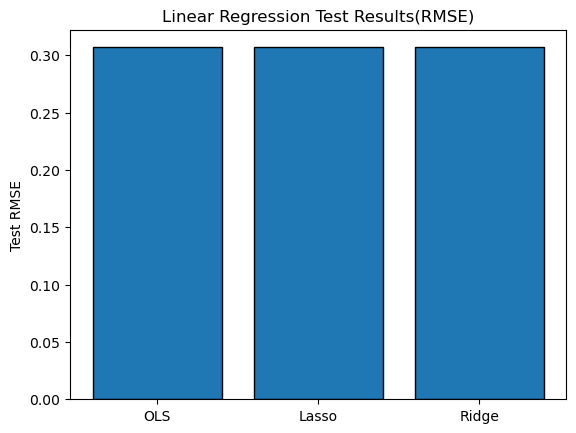

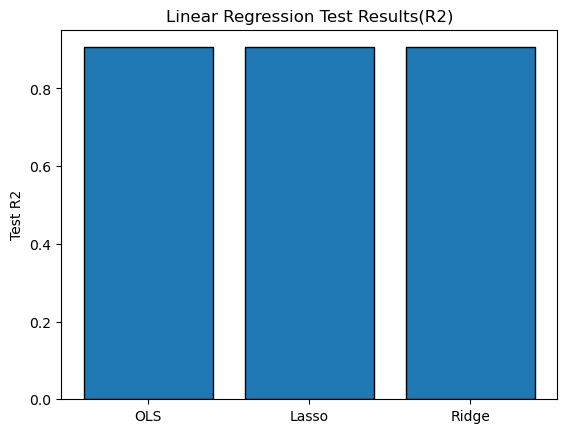

[0.30692312581679887, 0.3069262427883038, 0.3069078668918593]
[0.9056622517685481, 0.9056603356563919, 0.905671631686289]


In [19]:
#Test Results
rms_list = []
r2_list = []

clf = LinearRegression()
lr_fit = clf.fit(df_train_features_ss,np.array(df_train_labels_ss).ravel())
preds = lr_fit.predict(df_test_features_ss)

rms = mean_squared_error(df_test_labels_ss, preds, squared=False)
rms_list.append(rms)

r2 = r2_score(df_test_labels_ss,preds)
r2_list.append(r2)

clf = Lasso(alpha = 0.0001)
lr_fit = clf.fit(df_train_features_ss,np.array(df_train_labels_ss).ravel())
preds = lr_fit.predict(df_test_features_ss)

rms = mean_squared_error(df_test_labels_ss, preds, squared=False)
rms_list.append(rms)

r2 = r2_score(df_test_labels_ss,preds)
r2_list.append(r2)

clf = Ridge(alpha = 10)
lr_fit = clf.fit(df_train_features_ss,np.array(df_train_labels_ss).ravel())
preds = lr_fit.predict(df_test_features_ss)

rms = mean_squared_error(df_test_labels_ss, preds, squared=False)
rms_list.append(rms)

r2 = r2_score(df_test_labels_ss,preds)
r2_list.append(r2)


plt.bar(np.arange(1,4),rms_list, edgecolor = "Black")
plt.xticks(np.arange(1,4))
plt.title("Linear Regression Test Results(RMSE)")
plt.ylabel("Test RMSE")
plt.xticks([1,2,3], ["OLS", "Lasso","Ridge"])
plt.show()

plt.bar(np.arange(1,4),r2_list, edgecolor = "Black")
plt.xticks(np.arange(1,4))
plt.title("Linear Regression Test Results(R2)")
plt.ylabel("Test R2")
plt.xticks([1,2,3], ["OLS", "Lasso","Ridge"])
plt.show()

print(rms_list)
print(r2_list)

In [20]:
#Question 4.3
# Only preprocess Categorical variables

cat_cut_level = [['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']] 
cat_color_level = [['J', 'I', 'H', 'G', 'F', 'E', 'D']]
cat_clarity_level = [['I1', 'SI2', 'SI1', 'VS2','VS1', 'VVS2','VVS1', 'IF']]
cat_attributes= ["cut","color","clarity"]

full_pipeline_2 = ColumnTransformer(
    transformers = [
    ("cat_cut",     OrdinalEncoder(categories=cat_cut_level),["cut"]),
    ("cat_color",   OrdinalEncoder(categories=cat_color_level),["color"]),
    ("cat_clarity", OrdinalEncoder(categories=cat_clarity_level),["clarity"])
    ],
    remainder = "passthrough"
)
    

tf_cat_train_features = full_pipeline_2.fit_transform(train_features)
tf_cat_test_features = full_pipeline_2.transform(test_features)

if(full_pipeline_2.sparse_output_):
    tf_cat_train_features = tf_cat_train_features.toarray()
    tf_cat_test_features = tf_cat_test_features.toarray()
    
#Make them dataframe
df_tf_cat_train_features = pd.DataFrame(tf_cat_train_features, columns = cat_attributes + num_attributes)
df_tf_cat_test_features  = pd.DataFrame(tf_cat_test_features, columns =  cat_attributes + num_attributes)

In [21]:
print(df_tf_cat_train_features[df_tf_cat_train_features.isna().any(axis=1)])
print(df_tf_cat_train_features[df_tf_cat_train_features.isnull().any(axis=1)])

Empty DataFrame
Columns: [cut, color, clarity, carat, depth, table, x, y, z]
Index: []
Empty DataFrame
Columns: [cut, color, clarity, carat, depth, table, x, y, z]
Index: []


Text(0.5, 1.0, 'Distribution of table')

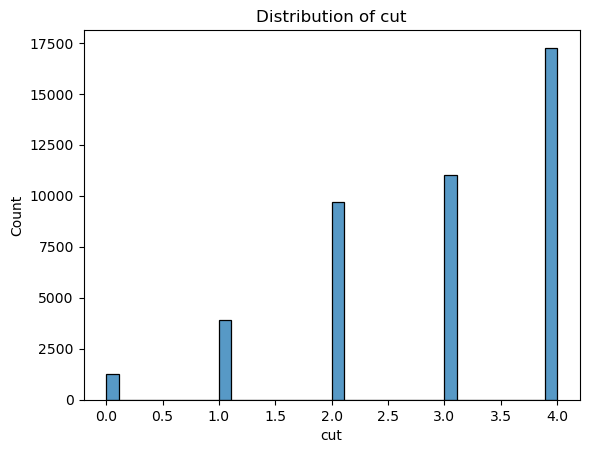

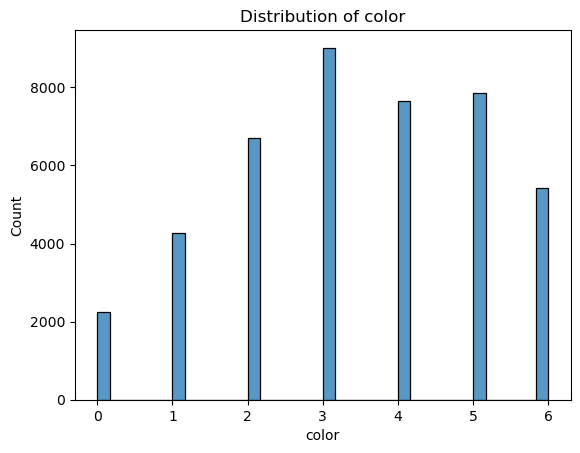

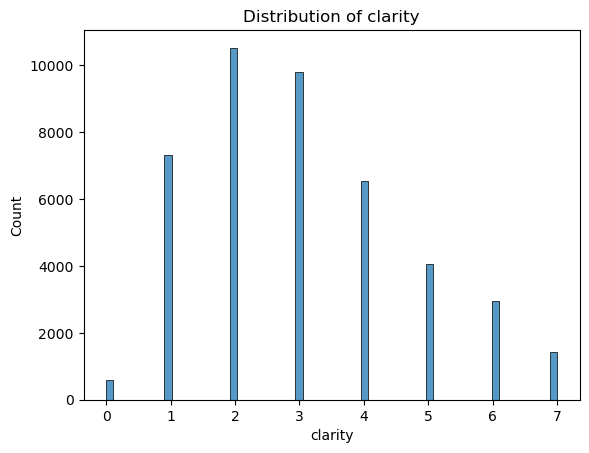

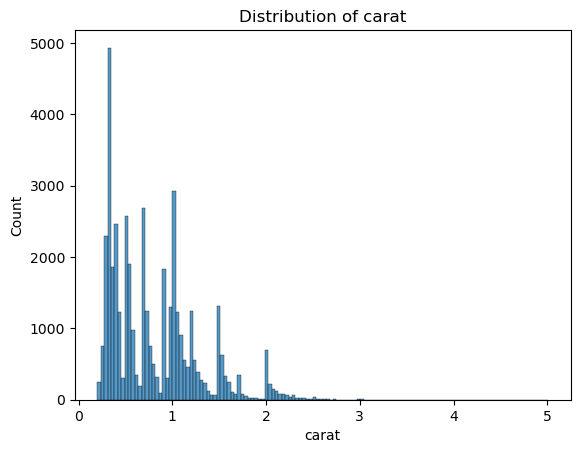

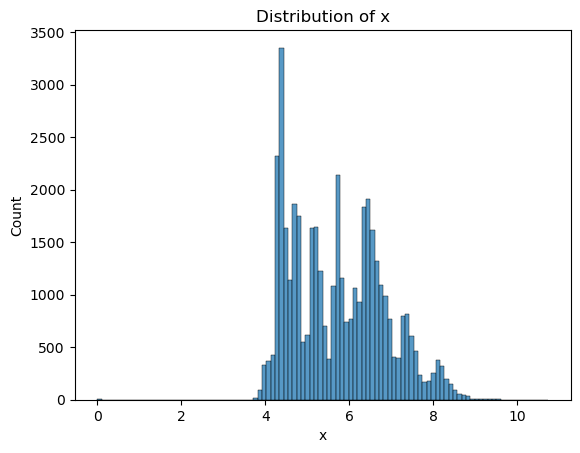

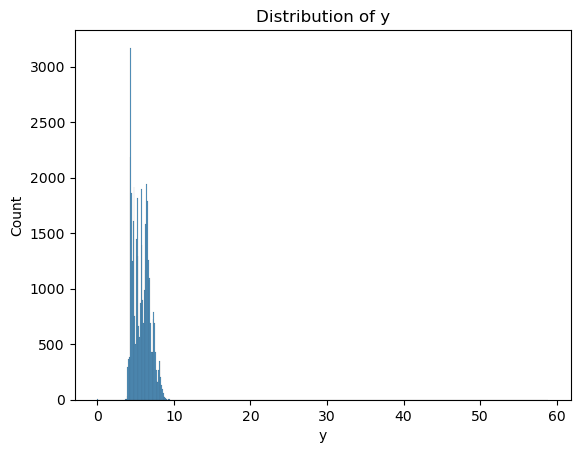

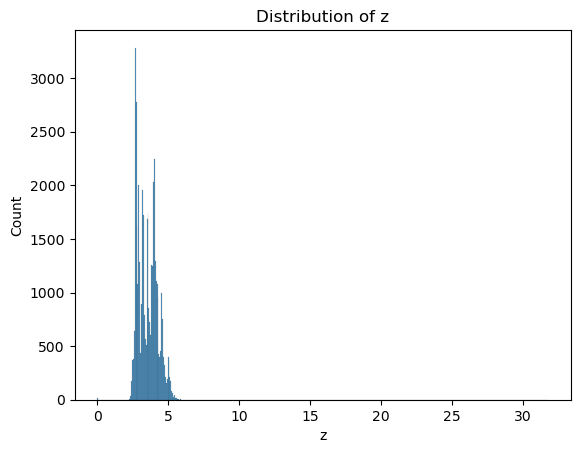

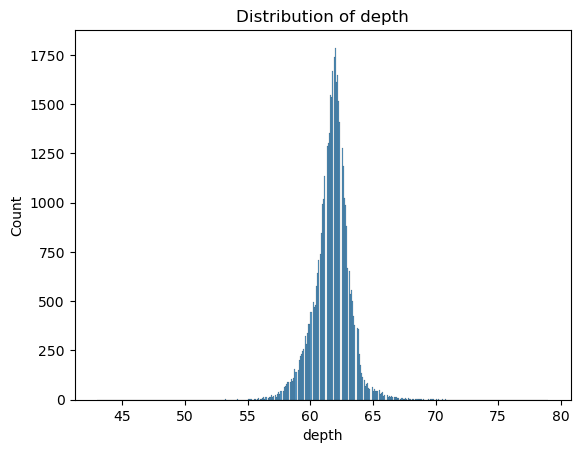

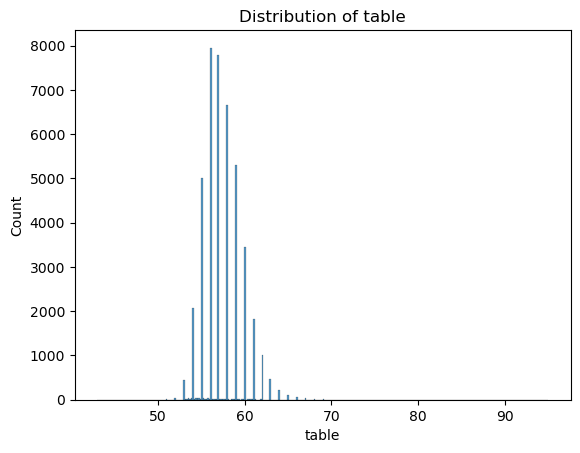

In [22]:
plt.figure()
sns.histplot(x ="cut", data = df_tf_cat_train_features,palette="Spectral")
plt.title("Distribution of cut")

plt.figure()
sns.histplot(x ="color", data = df_tf_cat_train_features,palette="Spectral")
plt.title("Distribution of color")

plt.figure()
sns.histplot(x ="clarity", data = df_tf_cat_train_features,palette="Spectral")
plt.title("Distribution of clarity")

plt.figure()
sns.histplot(x ="carat", data = df_tf_cat_train_features,palette="Spectral")
plt.title("Distribution of carat")

plt.figure()
sns.histplot(x ="x", data = df_tf_cat_train_features,palette="Spectral")
plt.title("Distribution of x")

plt.figure()
sns.histplot(x ="y", data = df_tf_cat_train_features,palette="Spectral")
plt.title("Distribution of y")

plt.figure()
sns.histplot(x ="z", data = df_tf_cat_train_features,palette="Spectral")
plt.title("Distribution of z")

plt.figure()
sns.histplot(x ="depth", data = df_tf_cat_train_features,palette="Spectral")
plt.title("Distribution of depth")

plt.figure()
sns.histplot(x ="table", data = df_tf_cat_train_features,palette="Spectral")
plt.title("Distribution of table")

In [23]:
clf = LinearRegression()
cv_results = cross_validate(clf, df_tf_cat_train_features, train_labels, cv=10, scoring = ("neg_root_mean_squared_error",'r2'))
print("Cross validation results for OLS with non-scaled(rmse): ", -cv_results['test_neg_root_mean_squared_error'].mean())
print("Cross validation results for OLS with non-scaled(r^2): ", cv_results['test_r2'].mean())

cv_results = cross_validate(clf, df_train_features_ss, df_train_labels_ss, cv=10, scoring = ("neg_root_mean_squared_error",'r2'))
print("Cross validation results for OLS with scaled(rmse): ", -cv_results['test_neg_root_mean_squared_error'].mean())
print("Cross validation results for OLS with scaled(r^2): ", cv_results['test_r2'].mean())

Cross validation results for OLS with non-scaled(rmse):  1215.3611477778304
Cross validation results for OLS with non-scaled(r^2):  0.9071118901262294
Cross validation results for OLS with scaled(rmse):  0.30460500670267604
Cross validation results for OLS with scaled(r^2):  0.9071118901262294


In [24]:
alphas = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,1e1,1e2,1e3,1e4,1e5,1e6,1e7,1e8]
rmse_list = []
r2_list = []
rmse_list_non = []
r2_list_non = []
for alpha in alphas:
    clf = Ridge(alpha = alpha)
    cv_results = cross_validate(clf, df_train_features_ss, df_train_labels_ss, cv=10, scoring = ("neg_root_mean_squared_error",'r2'))
    rmse_list.append(cv_results['test_neg_root_mean_squared_error'].mean())
    r2_list.append(cv_results['test_r2'].mean())
    
    clf = Ridge(alpha = alpha)
    cv_results = cross_validate(clf, df_tf_cat_train_features, train_labels, cv=10, scoring = ("neg_root_mean_squared_error",'r2'))
    rmse_list_non.append(cv_results['test_neg_root_mean_squared_error'].mean())
    r2_list_non.append(cv_results['test_r2'].mean())

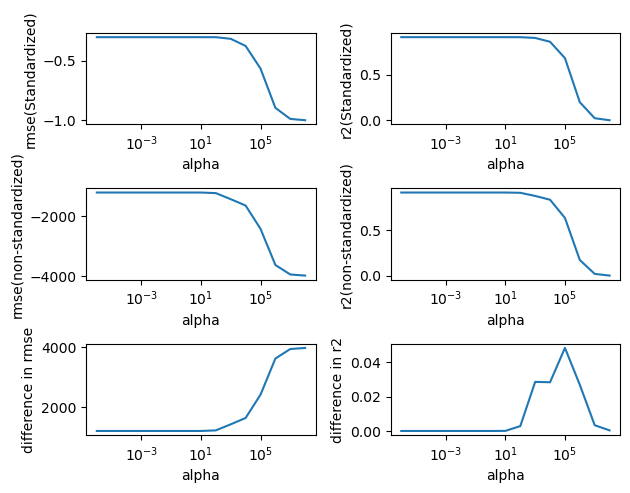

In [25]:
fig = plt.figure()
fig.set_tight_layout(True)
ax1 = fig.add_subplot(3, 2, 1)
ax1.plot(alphas, rmse_list)
ax1.set_xscale('log')
ax1.set_xlabel("alpha")
ax1.set_ylabel("rmse(Standardized)")

ax2 = fig.add_subplot(3, 2, 2)
ax2.plot(alphas, r2_list)
ax2.set_xscale('log')
ax2.set_xlabel("alpha")
ax2.set_ylabel("r2(Standardized)")

ax3 = fig.add_subplot(3, 2, 3)
ax3.plot(alphas, rmse_list_non)
ax3.set_xscale('log')
ax3.set_xlabel("alpha")
ax3.set_ylabel("rmse(non-standardized)")

ax4 = fig.add_subplot(3, 2, 4)
ax4.plot(alphas, r2_list_non)
ax4.set_xscale('log')
ax4.set_xlabel("alpha")
ax4.set_ylabel("r2(non-standardized)")

dif2 = np.array(r2_list) - np.array(r2_list_non)
dif1 = np.array(rmse_list) - np.array(rmse_list_non)

ax4 = fig.add_subplot(3, 2, 5)
ax4.plot(alphas, dif1)
ax4.set_xscale('log')
ax4.set_xlabel("alpha")
ax4.set_ylabel("difference in rmse")

ax4 = fig.add_subplot(3, 2, 6)
ax4.plot(alphas, dif2)
ax4.set_xscale('log')
ax4.set_xlabel("alpha")
ax4.set_ylabel("difference in r2")


plt.show()


In [26]:
print("Best alpha for Ridge(rmse)(Standardized):", alphas[np.argmax(rmse_list)])
print("Best alpha for Ridge(r2)(Standardized):", alphas[np.argmax(r2_list)])
print("Best alpha for Ridge(rmse)(non-Standardized):", alphas[np.argmax(rmse_list_non)])
print("Best alpha for Ridge(r2)(non-Standardized):", alphas[np.argmax(r2_list_non)])

Best alpha for Ridge(rmse)(Standardized): 10.0
Best alpha for Ridge(r2)(Standardized): 10.0
Best alpha for Ridge(rmse)(non-Standardized): 1
Best alpha for Ridge(r2)(non-Standardized): 1


In [27]:
print("Best rmse for Ridge(rmse)(Standardized):", -np.max(rmse_list))
print("Best r2 for Ridge(r2)(Standardized):", np.max(r2_list))
print("Best rmse for Ridge(rmse)(non-Standardized):", -np.max(rmse_list_non))
print("Best r2 for Ridge(r2)(non-Standardized):", np.max(r2_list_non))

Best rmse for Ridge(rmse)(Standardized): 0.30458073386693996
Best r2 for Ridge(r2)(Standardized): 0.9071283394549947
Best rmse for Ridge(rmse)(non-Standardized): 1215.3568312664615
Best r2 for Ridge(r2)(non-Standardized): 0.907113075634086


In [28]:
alphas = [1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1,1e1,1e2,1e3,1e4,1e5,1e6,1e7,1e8]
rmse_list = []
r2_list = []
rmse_list_non = []
r2_list_non = []
for alpha in alphas:
    clf = Lasso(alpha = alpha)
    cv_results = cross_validate(clf, df_train_features_ss, df_train_labels_ss, cv=10, scoring = ("neg_root_mean_squared_error",'r2'))
    rmse_list.append(cv_results['test_neg_root_mean_squared_error'].mean())
    r2_list.append(cv_results['test_r2'].mean())
    
    clf = Ridge(alpha = alpha)
    cv_results = cross_validate(clf, df_tf_cat_train_features, train_labels, cv=10, scoring = ("neg_root_mean_squared_error",'r2'))
    rmse_list_non.append(cv_results['test_neg_root_mean_squared_error'].mean())
    r2_list_non.append(cv_results['test_r2'].mean())

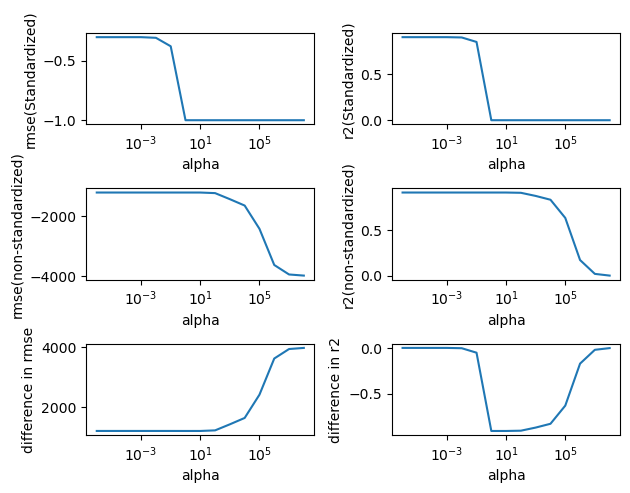

In [29]:
fig = plt.figure()
fig.set_tight_layout(True)
ax1 = fig.add_subplot(3, 2, 1)
ax1.plot(alphas, rmse_list)
ax1.set_xscale('log')
ax1.set_xlabel("alpha")
ax1.set_ylabel("rmse(Standardized)")

ax2 = fig.add_subplot(3, 2, 2)
ax2.plot(alphas, r2_list)
ax2.set_xscale('log')
ax2.set_xlabel("alpha")
ax2.set_ylabel("r2(Standardized)")

ax3 = fig.add_subplot(3, 2, 3)
ax3.plot(alphas, rmse_list_non)
ax3.set_xscale('log')
ax3.set_xlabel("alpha")
ax3.set_ylabel("rmse(non-standardized)")

ax4 = fig.add_subplot(3, 2, 4)
ax4.plot(alphas, r2_list_non)
ax4.set_xscale('log')
ax4.set_xlabel("alpha")
ax4.set_ylabel("r2(non-standardized)")

dif2 = np.array(r2_list) - np.array(r2_list_non)
dif1 = np.array(rmse_list) - np.array(rmse_list_non)

ax4 = fig.add_subplot(3, 2, 5)
ax4.plot(alphas, dif1)
ax4.set_xscale('log')
ax4.set_xlabel("alpha")
ax4.set_ylabel("difference in rmse")

ax4 = fig.add_subplot(3, 2, 6)
ax4.plot(alphas, dif2)
ax4.set_xscale('log')
ax4.set_xlabel("alpha")
ax4.set_ylabel("difference in r2")


plt.show()


In [30]:
print("Best alpha for Lasso(rmse)(Standardized):", alphas[np.argmax(rmse_list)])
print("Best alpha for Lasso(r2)(Standardized):", alphas[np.argmax(r2_list)])
print("Best alpha for Lasso(rmse)(non-Standardized):", alphas[np.argmax(rmse_list_non)])
print("Best alpha for Lasso(r2)(non-Standardized):", alphas[np.argmax(r2_list_non)])

Best alpha for Lasso(rmse)(Standardized): 0.0001
Best alpha for Lasso(r2)(Standardized): 0.0001
Best alpha for Lasso(rmse)(non-Standardized): 1
Best alpha for Lasso(r2)(non-Standardized): 1


In [31]:
print("Best rmse for Lasso(rmse)(Standardized):", -np.max(rmse_list))
print("Best r2 for Lasso(r2)(Standardized):", np.max(r2_list))
print("Best rmse for Lasso(rmse)(non-Standardized):", -np.max(rmse_list_non))
print("Best r2 for Lasso(r2)(non-Standardized):", np.max(r2_list_non))

Best rmse for Lasso(rmse)(Standardized): 0.3045371804770201
Best r2 for Lasso(r2)(Standardized): 0.9071547552626811
Best rmse for Lasso(rmse)(non-Standardized): 1215.3568312664615
Best r2 for Lasso(r2)(non-Standardized): 0.907113075634086


In [32]:
X = np.array(df_train_features_ss)
Y = np.array(df_train_labels_ss)
X = sm.add_constant(X)
model = sm.OLS(Y,X)
results = model.fit()
feature_name_list = ['constant'] + list(df_train_features_ss.columns)
print(results.summary(xname = feature_name_list))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.907
Model:                            OLS   Adj. R-squared:                  0.907
Method:                 Least Squares   F-statistic:                 4.694e+04
Date:                Fri, 17 Mar 2023   Prob (F-statistic):               0.00
Time:                        23:18:02   Log-Likelihood:                -9905.6
No. Observations:               43152   AIC:                         1.983e+04
Df Residuals:                   43142   BIC:                         1.992e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
constant     2.96e-17      0.001   2.02e-14      1.0

In [33]:
print(results.pvalues)
print(results.pvalues > 0.05) # True's are insignificant H0 = 0, do not reject null hypothesis, reject for falses.

[1.00000000e+000 1.69820545e-083 0.00000000e+000 0.00000000e+000
 0.00000000e+000 3.45686875e-053 2.33039657e-016 9.40317476e-123
 2.70785107e-001 6.65306690e-001]
[ True False False False False False False False  True  True]


RMS with y,z:  0.30757513955397314
R2 with y,z:  0.9052610122618255
RMS without y,z:  0.30692312581679887
R2 without y,z:  0.9056622517685481


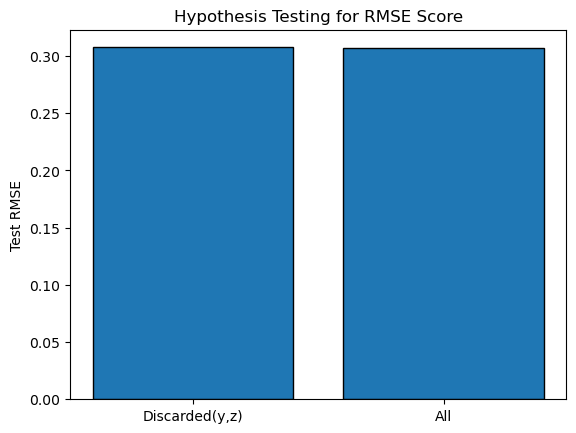

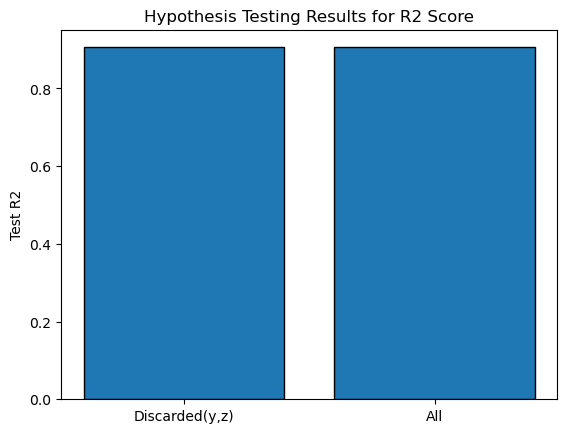

In [34]:
rms_list_hypo = []
r2_list_hypo = []
#Compare performance with y,z and without y,z

selected_idx = [0,1,2,3,6,7,8]
selected_train_features = np.array(df_train_features_ss)[:,selected_idx]
selected_test_features = np.array(df_test_features_ss)[:,selected_idx]
lr_fit = LinearRegression().fit(selected_train_features,df_train_labels_ss)
preds = lr_fit.predict(selected_test_features)
rms = mean_squared_error(df_test_labels_ss, preds, squared=False)
rms_list_hypo.append(rms)
r2 = r2_score(df_test_labels_ss, preds)
r2_list_hypo.append(r2)
print("RMS with y,z: ", rms)
print("R2 with y,z: ", r2)

selected_idx = [0,1,2,3,4,5,6,7,8]
selected_train_features = np.array(df_train_features_ss)[:,selected_idx]
selected_test_features = np.array(df_test_features_ss)[:,selected_idx]
lr_fit = LinearRegression().fit(selected_train_features,df_train_labels_ss)
preds = lr_fit.predict(selected_test_features)
rms = mean_squared_error(df_test_labels_ss, preds, squared=False)
rms_list_hypo.append(rms)
r2 = r2_score(df_test_labels_ss, preds)
r2_list_hypo.append(r2)
print("RMS without y,z: ", rms)
print("R2 without y,z: ", r2)
      
#Therefore, y and z are redundant
plt.bar(np.arange(1,3),rms_list_hypo ,edgecolor = "Black")
plt.xticks(np.arange(1,3))
plt.title("Hypothesis Testing for RMSE Score")
plt.ylabel("Test RMSE")
plt.xticks([1,2], ["Discarded(y,z)", "All"])
plt.show()
      
plt.bar(np.arange(1,3),r2_list_hypo, edgecolor = "Black")
plt.xticks(np.arange(1,3))
plt.title("Hypothesis Testing Results for R2 Score")
plt.ylabel("Test R2")
plt.xticks([1,2], ["Discarded(y,z)", "All"])
plt.show()